In [1]:
import os
import re 
import sys

sys.path.insert(0, os.path.abspath('../../../'))

import torch
from PIL import Image, ImageDraw

import time
from IPython.display import HTML
from base64 import b64encode
import textwrap
import requests
import urllib.request

from core.args import dataclass_from_dict
from core.transforms.image_transform import get_image_transform
# from core.transforms.video_transform import get_video_transform
from apps.plm.generate_reg import GeneratorArgs, LMGenerator
from apps.plm.generate import load_consolidated_model_and_tokenizer

/Users/deekshith/Documents/Projects/multimodal_models/mlx_perception_models/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
ckpt = "mlx-community/Perception-LM-1B"
# ckpt = "facebook/Perception-LM-3B" 
# ckpt = "facebook/Perception-LM-8B" 
model, tokenizer, config = load_consolidated_model_and_tokenizer(ckpt)

INFO:apps.plm.tokenizer:#words: 128256 - BOS ID: 128000 - EOS ID: 128001
INFO:apps.plm.transformer:Initializing PE_VisionTransformer with args: {'image_size': 448, 'patch_size': 14, 'width': 1024, 'layers': 23, 'heads': 16, 'use_cls_token': True, 'use_abs_posemb': True, 'ls_init_value': 0.1, 'drop_path': 0.1, 'mlp_ratio': 4.0, 'use_ln_post': False, 'pool_type': 'none'}


In [3]:
def generate(
    media_path,
    question="Describe the image in details.",
    media_type="image",
    number_of_frames=4,
    number_of_tiles=1,
    temperature=0.0,
    top_p=None,
    top_k=None,
    return_text=False,
):
    prompts = []
    if media_type == "image":
        transform = get_image_transform(
            vision_input_type=(
                "vanilla" if number_of_tiles == 1 else config.data.vision_input_type
            ),
            image_res=model.vision_model.image_size,
            max_num_tiles=number_of_tiles,
        )
        if isinstance(media_path, str):
            image = Image.open(media_path).convert("RGB")
        else:
            image = media_path
        image, _ = transform(image)
        prompts.append((question, image))
    # elif media_type == "video":
    #     transform = get_video_transform(
    #         image_res=model.vision_model.image_size,
    #     )
    #     video_info = (media_path, number_of_frames, None, None, None)
    #     frames, _ = transform(video_info)
    #     prompts.append((question, frames))
    else:
        raise NotImplementedError(
            f"The provided generate function only supports image and video."
        )
    # Create generator
    gen_cfg = dataclass_from_dict(
        GeneratorArgs,
        {"temperature": temperature, "top_p": top_p, "top_k": top_k},
        strict=False,
    )
    generator = LMGenerator(gen_cfg, model, tokenizer)
    # Run generation
    start_time = time.time()
    generation = generator.generate(prompts[0])
    end_time = time.time()
    if return_text:
        print(generation)
        return generation

    # Calculate tokens per second
    total_tokens = sum(
        len(tokenizer.encode(gen, False, False)) for gen in generation
    )
    tokens_per_second = total_tokens / (end_time - start_time)
    print("=================================================")
    print(textwrap.fill(generation, width=75))
    print(f"Tokens per second: {tokens_per_second:.2f}")
    print("=================================================")

def extract_all_bounding_boxes(text: str) -> list[list[str]]:
    """Extracts any list of arbitrary length from a string."""
    pattern = r"\[\s*([^\[\]]*?)\s*\]"
    extracted_lists = [
        [num.strip() for num in match.split(",")] for match in re.findall(pattern, text)
    ]
    return extracted_lists

def rescale_2d_bboxes(bboxes, img_w, img_h, box_format="000", verbose=True):
    w, h = img_w, img_h
    rescaled_bboxes = []
    for bbox in bboxes:
        try:
            if box_format == "000":
                bbox = [float("0." + b.strip()) for b in bbox]
            elif box_format == "standard":
                bbox = [float(b.strip()) for b in bbox]
            else:
                # we don't know the format. try both
                try:
                    bbox = [float("0." + b.strip()) for b in bbox]
                except:
                    bbox = [float(b.strip()) for b in bbox]

            x1, y1, x2, y2 = bbox
            bbox = [x1 * w, y1 * h, x2 * w, y2 * h]

            rescaled_bboxes.append(bbox)
        except Exception as e:
            if verbose:
                print("[rescale_2d_bboxes]:", e, bbox, flush=True)
            pass
    return rescaled_bboxes

def postprocess_grounding(x: str, img_w: int, img_h: int) -> list[float]:
    bboxes = extract_all_bounding_boxes(x)
    bboxes = rescale_2d_bboxes(bboxes, img_w, img_h)
    if len(bboxes) > 0:
        box = bboxes[0]
    else:
        # no box found.
        box = [0, 0, img_w, img_h]
    return box


def generate_grounding(media_path: str, question: str, number_of_tiles: int):
    image = Image.open(media_path)
    w, h = image.size

    print("Generating...")
    output = generate(media_path=media_path, question=question, number_of_tiles=number_of_tiles, media_type="image", return_text=True)

    box = postprocess_grounding(output, w, h)

    draw = ImageDraw.Draw(image)
    try:
        x_min, y_min, x_max, y_max = box

        if x_min < x_max and y_min < y_max:
            # Draw the bounding box
            draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
    except Exception as e:
        print(f"Error drawing bounding box: {e}")
    return image

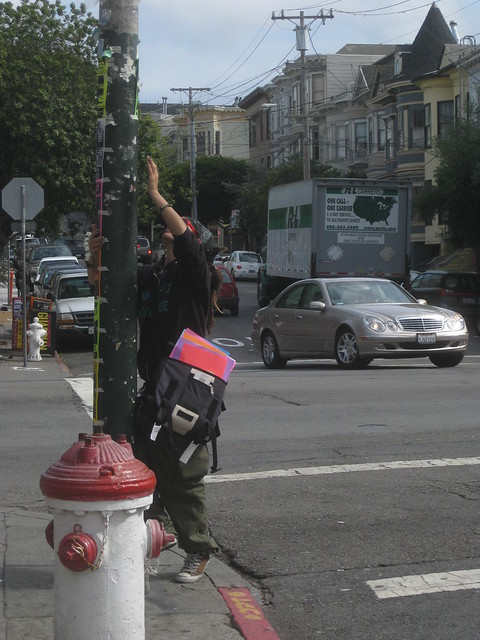

INFO:root:VariableSizeImageTransform size: 448
INFO:root:ImageTransform size: 448
INFO:root:Initialized transforms with: vision_input_type: 'thumb+tile' and max_num_tiles: 36.


Generating...
[042,476,114,566]


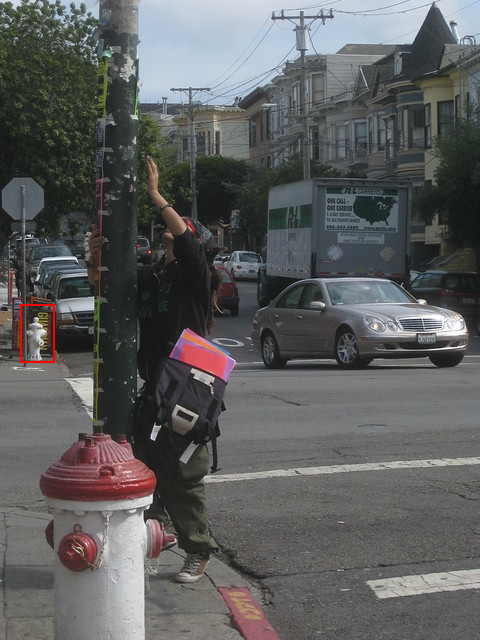

In [4]:
question_template = "Provide a bounding box of the region this sentence describes: '{caption}'.\nUse the format [x1, y1, x2, y2]."

image_url = "http://farm3.staticflickr.com/2453/3867429392_ed6f3d337a_z.jpg"
image_path = "3867429392_ed6f3d337a_z.jpg"

urllib.request.urlretrieve(image_url, image_path)

description = "white fire hydrant in the back"
question = question_template.format(caption=description)

img = Image.open(image_path)
display(img)

img_drawn = generate_grounding(media_path=image_path, question=question, number_of_tiles=36)
display(img_drawn)

### Region captioning (bounding box as text)

In [5]:
question = "Please describe the region ({bbox}) in details.\nThe region is in the format of [x1, y1, x2, y2]."
question = question.format(bbox="[040,482,112,576]")
generate(media_path=img_drawn, question=question, number_of_tiles=36, media_type="image")

INFO:root:VariableSizeImageTransform size: 448
INFO:root:ImageTransform size: 448
INFO:root:Initialized transforms with: vision_input_type: 'thumb+tile' and max_num_tiles: 36.


white fire hydrant on sidewalk.
Tokens per second: 0.40


### Region captioning (bounding box as drawing)

In [7]:
question = "Please describe the region inside the red rectangle."
generate(media_path=img_drawn, question=question, number_of_tiles=36, media_type="image")

INFO:root:VariableSizeImageTransform size: 448
INFO:root:ImageTransform size: 448
INFO:root:Initialized transforms with: vision_input_type: 'thumb+tile' and max_num_tiles: 36.


a white fire hydrant
Tokens per second: 0.35
